<a href="https://colab.research.google.com/github/attilalr/bootstrap-study/blob/main/bootstrap-study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bootstrap study
### How to use correctly the bootstrap technique

You can assess any statistical measure of population, here I'm gonna use a classification score from a trained model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
n_samples = 20000
n_features = 8

X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features,
                           class_sep=0.4,
                           )



dict_freq_labels = {}
print (f'Unique classes in y: {np.unique(y)}')
for label in np.unique(y):
    print (f'count of label {label}: {(y==label).sum()}')
    dict_freq_labels[label] = (y==label).sum()/y.size
print (dict_freq_labels)


rng = np.random.RandomState()

Unique classes in y: [0 1]
count of label 0: 10008
count of label 1: 9992
{0: 0.5004, 1: 0.4996}


### Looking for a 'true' score (using auc here)

Testing for several k-fold cross validation and a train/test set.

If all results gives the same score (regarding some decimal places) then its probably a good true result for the experiment.

In [3]:
clf = LogisticRegression()

print ('Results for k-fold cross-validation')

for cv in range(2,21):
    v = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    print (f'cv: {cv}, mean auc: {v.mean():.3f}, stddev: {v.std():.3f}')

# I'm setting the true score value as the last k, but you must confirm from the results
auc_true = v.mean()

print ()
print ('Result for training/test set, frac test_set=0.3')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=0.3,
                                shuffle=True, 
                                random_state=rng,
                                )

clf.fit(X_train, y_train)
print (f'{roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]):.3f}')
auc_score_train_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

Results for k-fold cross-validation
cv: 2, mean auc: 0.918, stddev: 0.002
cv: 3, mean auc: 0.918, stddev: 0.004
cv: 4, mean auc: 0.918, stddev: 0.003
cv: 5, mean auc: 0.918, stddev: 0.004
cv: 6, mean auc: 0.918, stddev: 0.004
cv: 7, mean auc: 0.918, stddev: 0.006
cv: 8, mean auc: 0.918, stddev: 0.006
cv: 9, mean auc: 0.918, stddev: 0.005
cv: 10, mean auc: 0.918, stddev: 0.006
cv: 11, mean auc: 0.918, stddev: 0.007
cv: 12, mean auc: 0.918, stddev: 0.006
cv: 13, mean auc: 0.918, stddev: 0.008
cv: 14, mean auc: 0.917, stddev: 0.007
cv: 15, mean auc: 0.918, stddev: 0.008
cv: 16, mean auc: 0.918, stddev: 0.010
cv: 17, mean auc: 0.918, stddev: 0.008
cv: 18, mean auc: 0.918, stddev: 0.008
cv: 19, mean auc: 0.918, stddev: 0.010
cv: 20, mean auc: 0.918, stddev: 0.011

Result for training/test set, frac test_set=0.3
0.915


### Now we are gonna simulate a small dataset. Sampling from the original distribution.

In [4]:
# will use test set as new sampled dataset
_, X1, _, y1 = train_test_split(X, y,
                                test_size=0.005,
                                shuffle=True, 
                                random_state=rng,
                                )

print (f'New dataset shape: {X1.shape}')

list_count = list()
for label in np.unique(y1):
    print (f'count of label {label}: {(y1==label).sum()}')
    list_count.append((y1==label).sum())

min_label_count = np.array(list_count).min()

New dataset shape: (100, 8)
count of label 0: 50
count of label 1: 50


### Here is what I see people doing

[Example]

[1] Given a dataset with 100 samples. 

[2] Sample 100 samples with replacement, train model / calculate the score.

[3] Repeat step 2, N times.

[4] Final step, calculate the mean score and the std of the mean, given by:

$$
\sigma_{mean} = \frac{\sigma}{\sqrt{N}}.
$$

The problem is to think that increasing $N$ will give a better mean score, with a narrower uncertainty.

Let's look at the generated figure. The mean and uncertainty of the mean calculated this way deviates clearly from the true score.

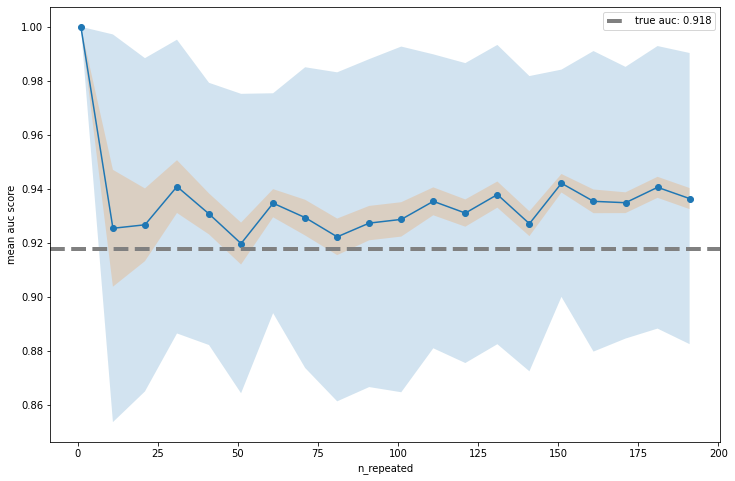

In [5]:
n_repeated_max = 200


list_of_mean_scores = list()
list_of_std_scores = list()
list_of_rep = list()


for n_repeated in range(1, n_repeated_max, 10):

    v = list()

    for i in range(n_repeated):


        idxs_bootstrap = np.random.choice(range(X1.shape[0]), size=X1.shape[0], replace=True)
        X_boots = X1[idxs_bootstrap, :]
        y_boots = y1[idxs_bootstrap]

        X_train, X_test, y_train, y_test = train_test_split(X_boots, y_boots,
                                                test_size=0.3,
                                                shuffle=True, 
                                                random_state=rng,
                                                )

        clf.fit(X_train, y_train)
        v.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    list_of_mean_scores.append(np.array(v).mean())
    list_of_std_scores.append(np.array(v).std())
    list_of_rep.append(n_repeated)

#
plt.figure(figsize=(12, 8))
plt.plot(list_of_rep, list_of_mean_scores, '-o')
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores), 
                 alpha=0.2)
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 alpha=0.2)
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('n_repeated')
plt.ylabel('mean auc score')
plt.legend()

### Did you see the error in the last cell?

I performed the bootstrap in $X_1$ and after that, the train/test split.

For example, if my data is

$$
[x_1, x_2, x_3, x_4, x_5, x_6, x_7],
$$

the bootstrap operation may return

$$
[x_2, x_2, x_1, x_7, x_6, x_6, x_3].
$$

After that we split in train/test:

$$
[x_2, x_1, x_7, x_6, x_3], [x_2, x_6]
$$

Now we have the same sample in training and test set ($x_2$ and $x_6$). This is bad! The trained model will have an unfair advantage and the score will not be realistic. It will be overestimated.

This kind of behaviour appears too in data augmentation as Oversampling and Smote. And in k-fold cross-validation too. This part it is not exactly related to bootstrap but is important.

### What we can do to continue the experiment?

I see two choices:

1 - We perform the bootstrap in the training set, after the split. The test set will remain as it is;

2 - Use the OOB Out-Of-Bag technique.

I expect both cases to result in a lower score, but a correct one. 
Let's do both. First the number 1.



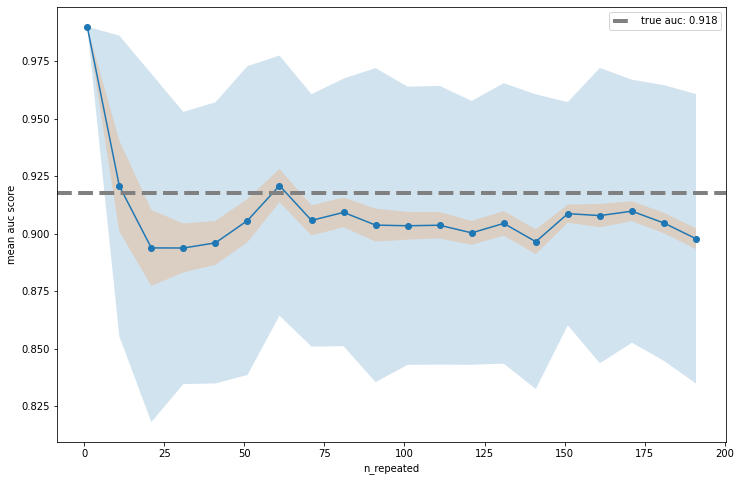

In [6]:
n_repeated_max = 200


list_of_mean_scores = list()
list_of_std_scores = list()
list_of_rep = list()


for n_repeated in range(1, n_repeated_max, 10):

    v = list()

    for i in range(n_repeated):

        # this part is different
        X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                                test_size=0.3,
                                                shuffle=True, 
                                                random_state=rng,
                                                )

        idxs_bootstrap = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
        X_train = X_train[idxs_bootstrap, :]
        y_train = y_train[idxs_bootstrap]
        #

        clf.fit(X_train, y_train)
        v.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    list_of_mean_scores.append(np.array(v).mean())
    list_of_std_scores.append(np.array(v).std())
    list_of_rep.append(n_repeated)

#
plt.figure(figsize=(12, 8))
plt.plot(list_of_rep, list_of_mean_scores, '-o')
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores), 
                 alpha=0.2)
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 alpha=0.2)
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('n_repeated')
plt.ylabel('mean auc score')
plt.legend()

Yes. Considering the bootstrap is correct we can see that using the stddev of the mean as $\frac{\sigma}{\sqrt(N)}$ (orange area) is not a good idea. It does not make sense to resample $N\to\infty$ and have a zero standard deviation for the score mean. Remember that we are reusing the same population.

The blue area is showing a hint. It is the stddev of the score. We can see it stabilizes around $N=50$. This is because the uncertainty of the standard deviation, let's call $S_{\sigma}$ is

$$
S_\sigma = \frac{\sigma}{\sqrt{2(N-1)}}.
$$

For $N=50$:

$$
S\_sigma(N=50) = \frac{\sigma}{\sqrt{2\cdot 49}} = \frac{\sigma}{9,99}.
$$

The expression says that the uncertainty of the standard deviation is about one-tenth of the standard deviation value.

Another question is: if we perform the train/test split $N$ times? Let's see...

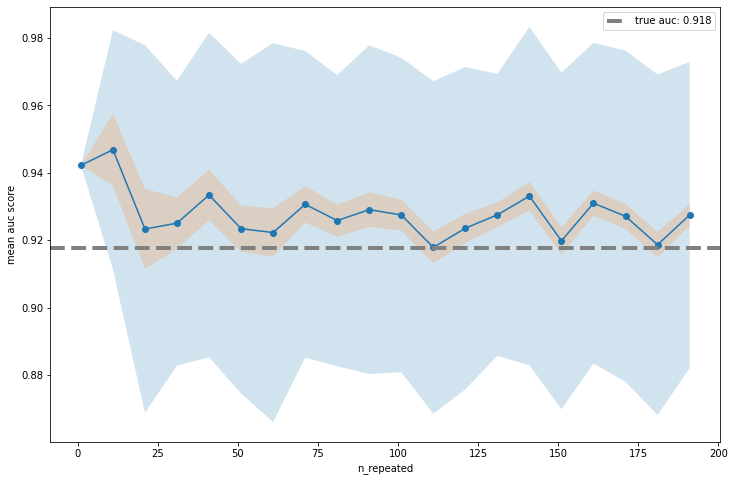

In [7]:
n_repeated_max = 200


list_of_mean_scores = list()
list_of_std_scores = list()
list_of_rep = list()


for n_repeated in range(1, n_repeated_max, 10):

    v = list()

    for i in range(n_repeated):

        # this part is different
        X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                                test_size=0.3,
                                                shuffle=True, 
                                                random_state=rng,
                                                )

        #idxs_bootstrap = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
        #X_train = X_train[idxs_bootstrap, :]
        #y_train = y_train[idxs_bootstrap]
        #

        clf.fit(X_train, y_train)
        v.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    list_of_mean_scores.append(np.array(v).mean())
    list_of_std_scores.append(np.array(v).std())
    list_of_rep.append(n_repeated)

#
plt.figure(figsize=(12, 8))
plt.plot(list_of_rep, list_of_mean_scores, '-o')
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores), 
                 alpha=0.2)
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 alpha=0.2)
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('n_repeated')
plt.ylabel('mean auc score')
plt.legend()

### But how bootstrap works then?

TODO here.

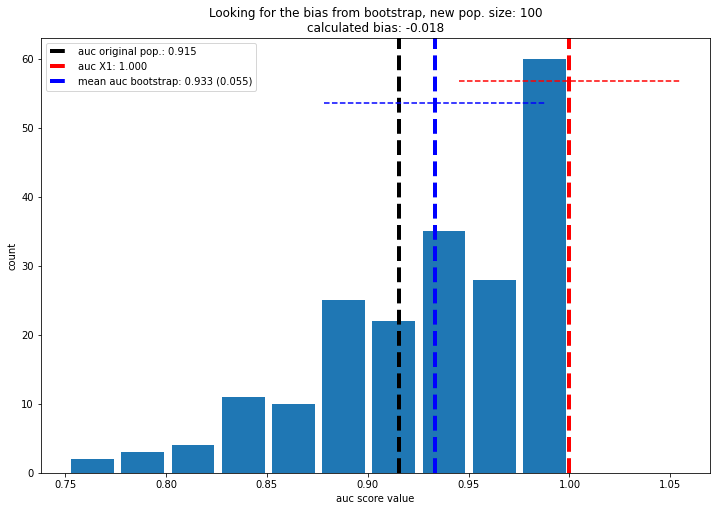

In [8]:
list_of_scores = list()

X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                        test_size=0.3,
                                        shuffle=True, 
                                        random_state=rng,
                                        )

clf.fit(X_train, y_train)
auc_X1 = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

for i in range(200):

    idxs_bootstrap = np.random.choice(range(X1.shape[0]), size=X1.shape[0], replace=True)
    #print (idxs_bootstrap)
    X_boots = X1[idxs_bootstrap, :]
    y_boots = y1[idxs_bootstrap]

    X_train, X_test, y_train, y_test = train_test_split(X_boots, y_boots,
                                            test_size=0.3,
                                            shuffle=True, 
                                            random_state=rng,
                                            )


    clf.fit(X_train, y_train)
    list_of_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.figure(figsize=(12, 8))
plt.hist(list_of_scores, rwidth=0.85)
plt.axvline(x=auc_score_train_test, lw=4, linestyle='--', color='black', label=f'auc original pop.: {auc_score_train_test:.3f}')
plt.axvline(x=auc_X1, lw=4, linestyle='--', color='red', label=f'auc X1: {auc_X1:.3f}')
plt.axvline(x=np.mean(list_of_scores), lw=4, linestyle='--', color='blue', label=f'mean auc bootstrap: {np.mean(list_of_scores):.3f} ({np.std(list_of_scores):.3f})')
plt.legend()
plt.title(f'Looking for the bias from bootstrap, new pop. size: {X1.shape[0]}\ncalculated bias: {auc_score_train_test-np.mean(list_of_scores):.3f}')
plt.xlabel('auc score value')
plt.ylabel('count')

axes = plt.gca()
y_min, y_max = axes.get_ylim()

plt.plot([np.mean(list_of_scores) - np.std(list_of_scores), np.mean(list_of_scores) + np.std(list_of_scores)], [y_max*0.85, y_max*0.85],
         linestyle='--',
         color='blue',)

plt.plot([auc_X1 - np.std(list_of_scores),auc_X1 + np.std(list_of_scores)], [y_max*0.9, y_max*0.9],
         linestyle='--',
         color='red',)

### Bootstrap evolution

### Using k-fold cross-validation

k-fold cross-validation varying k to see bias-variance phenomenon.

computing cv=10...
computing cv=20...
computing cv=30...
computing cv=40...


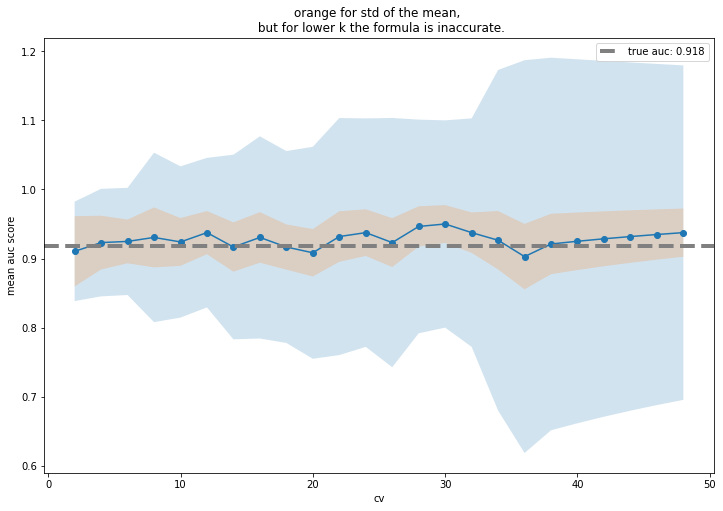

In [9]:
clf = LogisticRegression()

#n1 = X1.shape[0]//2

list_of_mean_scores = list()
list_of_std_scores = list()
list_of_cv = list()


for cv in range(2, min_label_count, 2):
    if cv % 10 == 0:
        print (f'computing cv={cv}...')
    v = cross_val_score(clf, X1, y1, cv=cv, scoring='roc_auc')
    #print (f'cv: {cv}, mean auc: {v.mean():.3f}, stddev: {v.std():.3f}')
    list_of_mean_scores.append(v.mean())
    list_of_std_scores.append(v.std())
    list_of_cv.append(cv)

plt.figure(figsize=(12, 8))
plt.plot(list_of_cv, list_of_mean_scores, '-o')
plt.fill_between(list_of_cv, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores), 
                 alpha=0.2)
plt.fill_between(list_of_cv, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores)/np.sqrt(list_of_cv), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores)/np.sqrt(list_of_cv), 
                 alpha=0.2)
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('cv')
plt.ylabel('mean auc score')
plt.title('orange for std of the mean, \n but for lower k the formula is inaccurate.')
plt.legend()

### Appendice stuff, dont know if I gonna use it.

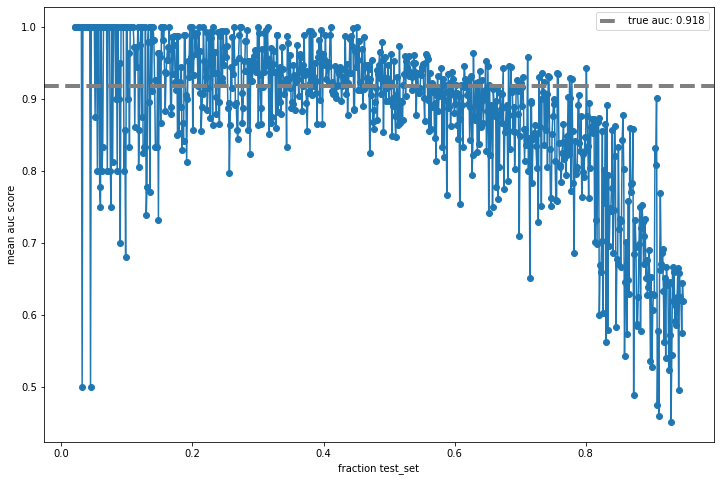

In [10]:
vector_fraction_test_set = np.linspace(0.02, 0.95, 800)

list_of_scores = list()
list_of_frac = list()

for fraction_test_set in vector_fraction_test_set:
    X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                            test_size=fraction_test_set,
                                            shuffle=True, 
                                            random_state=rng,
                                            )


    try: # as vezes nao aparece todas as classes no grupo de training ou teste, por isso o try
        clf.fit(X_train, y_train)
        list_of_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    except:
        continue
    list_of_frac.append(fraction_test_set)


#
plt.figure(figsize=(12, 8))
plt.plot(list_of_frac, list_of_scores, '-o')
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('fraction test_set')
plt.ylabel('mean auc score')
plt.legend()